In [ ]:
# pip install scalecast --upgrade

In [19]:
# importing essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
import seaborn as sns
import pickle
from scalecast.Forecaster import Forecaster
import time
import os
import re

# Data Pre-processing

In [62]:
# Preprocessing of data
def preprocessing(df, start_time_str):
    '''takes in the data in the raw time format and processes to the actual datetime'''
    #initializing starting time on the file
    start_time = time.strptime(start_time_str, '%Y-%m-%d-%H-%M')
    start_time = time.mktime(start_time) - 4*60*60
    
    # compute and add col of measurement times in seconds since start time
    df["meas_time"] = df.sec + start_time + (df.day*86400)
 
    # add a datetime column
    df["datetime"] = pd.to_datetime(df["meas_time"], unit="s")
    df = df.drop(df.index[df.name == 'add'])
    df.dropna(inplace=True)
    
    val_mean_ = df["value"].mean() 
    val_std_ = df['value'].std()

    # df["value"] = (df["value"] - val_mean_)/val_std_
    
    return df

In [63]:
folder = "../data/02_23/"
#get sub folders with data and sort by ascending date
sub_dir = sorted(os.listdir(folder))
#filter for only valid sub-folders
files = []
file_filter = re.compile("[0-3][0-9]_to_[0-2][0-9]_start*")
for file in sub_dir:
    if file_filter.match(file):
        files.append(file)

#merge multiple days
df = pd.DataFrame()
for file in files:
    path = folder + file + '/' + "GOLAYSEQ.CSV"
    start_time = "2023-02-" + file[:2] + "-" + file[15:17] + "-" + file[18:20]

    df_dum = preprocessing(pd.read_csv(path), start_time)
    df = pd.concat([df, df_dum], ignore_index=True)

In [64]:
df

,day,sec,name,value,meas_time,datetime
0,0,601,1,780.0,1.675360e+09,2023-02-02 17:50:01
1,0,601,1,780.0,1.675360e+09,2023-02-02 17:50:01
2,0,601,1,780.0,1.675360e+09,2023-02-02 17:50:01
3,0,601,0,782.0,1.675360e+09,2023-02-02 17:50:01
4,0,601,1,780.0,1.675360e+09,2023-02-02 17:50:01
...,...,...,...,...,...,...
175995,3,34858,0,259.0,1.677294e+09,2023-02-25 02:55:58
175996,3,34858,0,261.0,1.677294e+09,2023-02-25 02:55:58
175997,3,34858,0,263.0,1.677294e+09,2023-02-25 02:55:58
175998,3,34858,1,333.0,1.677294e+09,2023-02-25 02:55:58


# Perform a cross-correlation analysis on a set of biomass measurements taken over time

/var/folders/6m/5pkl5r3951b4qgdppsky0l040000gn/T/ipykernel_34436/3624372157.py:27: MatplotlibDeprecationWarning: The epoch2num function was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use ``[date2num(datetime.utcfromtimestamp(t)) for t in e]`` or numpy.datetime64 types instead.
  measurement_times = mdates.epoch2num(df.meas_time.unique())


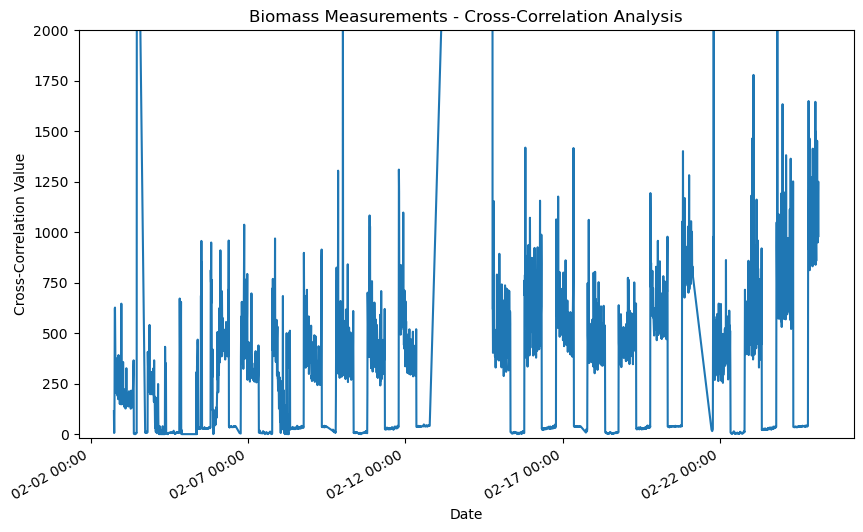

In [51]:

# defining golay sequences
golay_seq_a = [1,1,1,-1,1,1,-1,1,1,1,1,-1,-1,-1,1,-1,1,1,1,-1,1,1,-1,1,-1,-1,-1,1,1,1,-1]
golay_seq_b = [1,1,1,-1,1,1,-1,1,1,1,1,-1,-1,-1,1,-1,-1,-1,-1,1,-1,-1,1,-1,1,1,1,-1,-1,-1,1,-1]

# function performs cross-correlation analaysis
def cross_corr(a, b):
    '''takes as input two binary arrays a and b and returns their cross-correlation value'''
    a_binary = a - a.mean()
    b_binary = b - b.mean()
    
    xa = np.correlate(a_binary, ga, "full")
    xb = np.correlate(b_binary, gb, "full")
    
    return xa + xb

# Compute cross-correlation values for each measurement
#The maximum cross-correlation value for each measurement is stored in the cross_corr_values list
cross_corr_values = []
for meas_time in df.meas_time.unique():
    sub_df = df[df.meas_time == meas_time]
    laser_on = sub_df[1:33].value - sub_df[1:33].value.mean() # Laser on measurements
    laser_off = sub_df[33:].value - sub_df[33:].value.mean() # Laser off measurements
    cross_corr_value = np.correlate(laser_on, golay_seq_a, "full") + np.correlate(laser_off, golay_seq_b, "full")
    cross_corr_values.append(np.max(cross_corr_value)) # Store maximum cross-correlation value

# Convert measurement times to seconds since epoch for plotting
measurement_times = mdates.epoch2num(df.meas_time.unique())

# Set date format for x-axis labels
date_fmt = '%m-%d %H:%M'

# Use a DateFormatter to set the data to the correct format.
date_formatter = mdates.DateFormatter(date_fmt)
# Plot cross-correlation values vs. measurement time
plt.figure(figsize=(10,6))
plt.gca().xaxis.set_major_formatter(date_formatter)
plt.plot(measurement_times, cross_corr_values)
plt.gcf().autofmt_xdate()
plt.xlabel("Date")
plt.title("Biomass Measurements - Cross-Correlation Analysis")
plt.ylabel("Cross-Correlation Value")
plt.ylim([-20, 2000])
# plt.savefig("04_29_22/golay.jpg")
plt.show()

# Analog-Digital-Conversion of Data

/var/folders/6m/5pkl5r3951b4qgdppsky0l040000gn/T/ipykernel_34436/1997268680.py:12: MatplotlibDeprecationWarning: The epoch2num function was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use ``[date2num(datetime.utcfromtimestamp(t)) for t in e]`` or numpy.datetime64 types instead.
  secs_on = mdates.epoch2num(secs_on)
/var/folders/6m/5pkl5r3951b4qgdppsky0l040000gn/T/ipykernel_34436/1997268680.py:23: MatplotlibDeprecationWarning: The epoch2num function was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use ``[date2num(datetime.utcfromtimestamp(t)) for t in e]`` or numpy.datetime64 types instead.
  secs_off = mdates.epoch2num(secs_off)


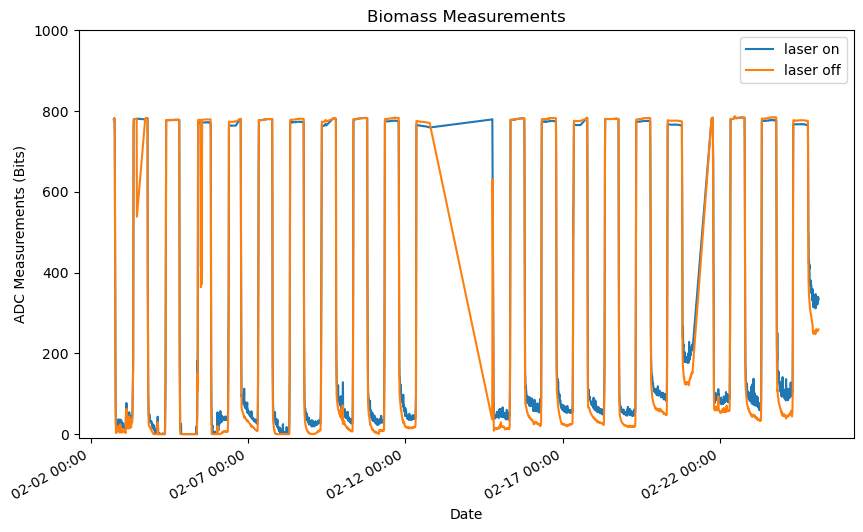

In [44]:
# Convert the measurement times to a numerical format that can be used in a plot
secs_on = []
val_on = []
for i in df.meas_time.unique():
    sub_df = df[df.meas_time == i]
    val = sub_df[sub_df.name == "1"].value
    if len(val) > 0:
        val_on.append(np.mean(val))
        secs_on.append(i)
        

secs_on = mdates.epoch2num(secs_on)

val_off = []
secs_off = []
for i in df.meas_time.unique():
    sub_df = df[df.meas_time == i]
    val = sub_df[sub_df.name == "0"].value
    if len(val) > 0:
        val_off.append(np.mean(val))
        secs_off.append(i)

secs_off = mdates.epoch2num(secs_off)

# Set the format for the date labels on the x-axis of the plot
date_fmt = '%m-%d %H:%M'

# Use a DateFormatter to set the data to the correct format.
date_formatter = mdates.DateFormatter(date_fmt)

# Create a figure and set the date formatter for the x-axis
plt.figure(figsize=(10,6))
plt.gca().xaxis.set_major_formatter(date_formatter)

# Plot the mean ADC measurements for laser on and off measurements as a function of time
plt.plot(secs_on, val_on)
plt.plot(secs_off, val_off)
plt.plot()

# Rotate the x-axis labels and add axis labels and a title to the plot
plt.gcf().autofmt_xdate()
plt.xlabel("Date")
plt.title("Biomass Measurements")
plt.ylabel("ADC Measurements (Bits)")

# Add a legend to the plot and set the y-axis limits
plt.legend(["laser on", "laser off"])
plt.ylim([-10,1000])

# Save the plot to a file and display it
# plt.savefig(date + "raw.jpg")
plt.show()

# Analog-Digital-Convertor for Nighttime Data

/var/folders/6m/5pkl5r3951b4qgdppsky0l040000gn/T/ipykernel_34436/2855560918.py:29: MatplotlibDeprecationWarning: The epoch2num function was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use ``[date2num(datetime.utcfromtimestamp(t)) for t in e]`` or numpy.datetime64 types instead.
  secs_on = mdates.epoch2num(secs_on)
/var/folders/6m/5pkl5r3951b4qgdppsky0l040000gn/T/ipykernel_34436/2855560918.py:30: MatplotlibDeprecationWarning: The epoch2num function was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use ``[date2num(datetime.utcfromtimestamp(t)) for t in e]`` or numpy.datetime64 types instead.
  secs_off = mdates.epoch2num(secs_off)


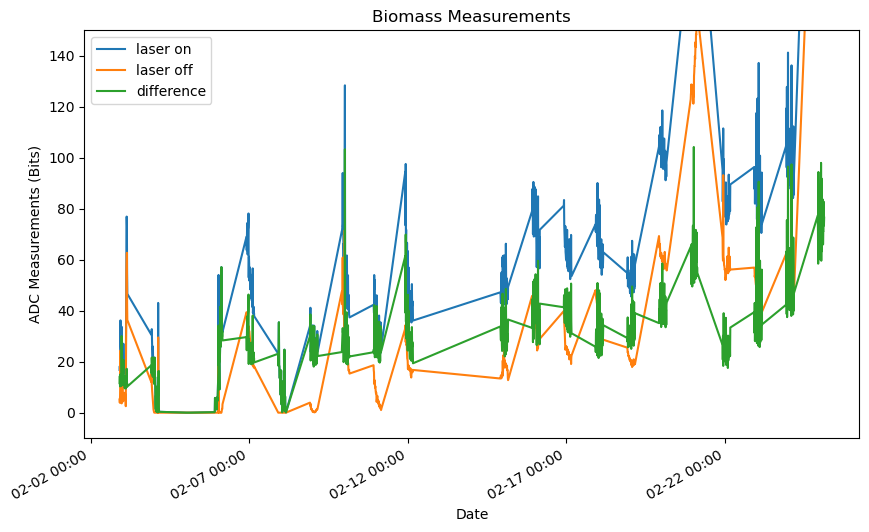

In [67]:

# Filter the data for the night time (10pm to 3am)
# night_data = df1
night_data = df[(df["datetime"].dt.hour >= 22) | (df["datetime"].dt.hour < 4)].copy()

val_on = []
secs_on = []
val_off = []
secs_off = []

# Compute mean ADC measurements for laser on and off measurements as a function of time
for i in night_data["meas_time"].unique():
    sub_ndf = night_data.loc[night_data["meas_time"] == i]
    val = sub_ndf.loc[sub_ndf["name"] == "1", "value"]
    if len(val) > 0:
        val_on.append(np.mean(val))
        secs_on.append(i)

for i in night_data["meas_time"].unique():
    sub_ndf = night_data.loc[night_data["meas_time"] == i]
    val = sub_ndf.loc[sub_ndf["name"] == "0", "value"]
    if len(val) > 0:
        val_off.append(np.mean(val))
        secs_off.append(i)

# compute difference
diff = np.array(val_on) - np.array(val_off)

# Convert measurement times to a numerical format that can be used in a plot
secs_on = mdates.epoch2num(secs_on)
secs_off = mdates.epoch2num(secs_off)

# Set the format for the date labels on the x-axis of the plot
date_fmt = '%m-%d %H:%M'

# Use a DateFormatter to set the data to the correct format.
date_formatter = mdates.DateFormatter(date_fmt)

# Create a figure and set the date formatter for the x-axis
plt.figure(figsize=(10,6))
plt.gca().xaxis.set_major_formatter(date_formatter)

# Plot the mean ADC measurements for laser on and off measurements as a function of time
plt.plot(secs_on, val_on)
plt.plot(secs_off, val_off)
plt.plot(secs_on, diff)
plt.plot()

# Rotate the x-axis labels and add axis labels and a title to the plot
plt.gcf().autofmt_xdate()
plt.xlabel("Date")
plt.title("Biomass Measurements")
plt.ylabel("ADC Measurements (Bits)")

# Add a legend to the plot and set the y-axis limits
plt.legend(["laser on", "laser off", "difference"])
plt.ylim([-10,150])

# Save the plot to a file and display it
# plt.savefig(date + "raw.jpg")
plt.show()

# LSTM Modelling for Forecasting

In [51]:
# normalizing the data

val_mean = night_data["value"].mean() 
val_std = night_data['value'].std()

night_data["value"] = (night_data["value"] - val_mean)/val_std

In [52]:
night_data.describe()

,day,sec,value,meas_time
count,47680.000000,47680.000000,4.768000e+04,4.768000e+04
mean,1.115436,27238.610738,6.044272e-14,1.676329e+09
std,0.970772,6480.323014,1.000000e+00,5.956543e+05
min,0.000000,14424.000000,-8.552429e-01,1.675375e+09
25%,0.000000,21636.000000,-5.913199e-01,1.675811e+09
50%,1.000000,27045.000000,-2.187227e-01,1.676419e+09
75%,2.000000,32454.000000,1.849242e-01,1.676855e+09
max,3.000000,42070.000000,5.478909e+00,1.677294e+09


In [53]:
# exploratory data analysis

f = Forecaster(y=night_data['value'],
               current_dates = night_data["datetime"]
)
f

Forecaster(
    DateStartActuals=2023-02-02T22:00:26.000000000
    DateEndActuals=2023-02-25T02:55:58.000000000
    Freq=None
    N_actuals=47680
    ForecastLength=0
    Xvars=[]
    TestLength=0
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

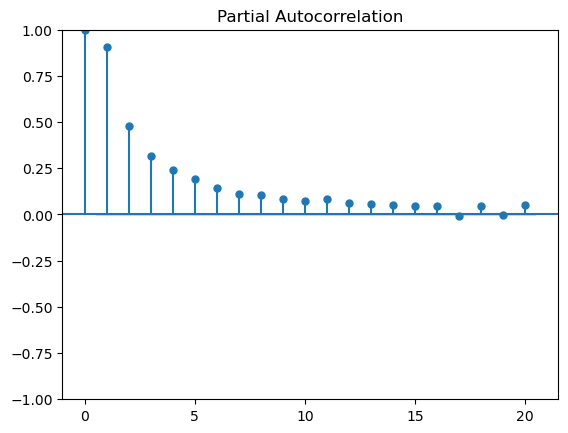

In [63]:
f.plot_pacf(lags=20)
plt.show()

In [57]:
night_data.set_index('datetime')
night_data.dropna(inplace=True)

In [67]:
# LSTM forecasting
# setting test length
f.set_test_length(10000)

# forecasting points
f.generate_future_dates(10000)
f.set_estimator('lstm')

Epoch 1/25
691/691 [==============================] - 26s 33ms/step - loss: 0.0793 - val_loss: 0.0907
Epoch 2/25
691/691 [==============================] - 22s 33ms/step - loss: 0.0764 - val_loss: 0.0947
Epoch 3/25
691/691 [==============================] - 24s 34ms/step - loss: 0.0761 - val_loss: 0.0924
Epoch 4/25
691/691 [==============================] - 23s 34ms/step - loss: 0.0755 - val_loss: 0.0928
Epoch 5/25
691/691 [==============================] - 24s 34ms/step - loss: 0.0748 - val_loss: 0.0922
Epoch 6/25
1/1 [==============================] - 1s 811ms/step
Epoch 1/25
941/941 [==============================] - 34s 32ms/step - loss: 0.0667 - val_loss: 0.0517
Epoch 2/25
941/941 [==============================] - 30s 32ms/step - loss: 0.0636 - val_loss: 0.0543
Epoch 3/25
941/941 [==============================] - 30s 32ms/step - loss: 0.0631 - val_loss: 0.0520
Epoch 4/25
941/941 [==============================] - 30s 32ms/step - loss: 0.0627 - val_loss: 0.0529
Epoch 5/25
941/941

C:\Users\local_admin\anaconda3\lib\site-packages\scalecast\_utils.py:55: Warning: Confidence intervals not found for lstm_2. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
C:\Users\local_admin\anaconda3\lib\site-packages\scalecast\_utils.py:55: Warning: Confidence intervals not found for lstm_1. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
C:\Users\local_admin\anaconda3\lib\site-packages\scalecast\_utils.py:55: Warning: Confidence intervals not found for lstm_layered. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
C:\Users\local_admin\anaconda3\lib\site-packages\scalecast\_utils.py:55: Warning: Confidence intervals not found for lstm_layered_2. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(


<AxesSubplot:xlabel='Date', ylabel='Values'>

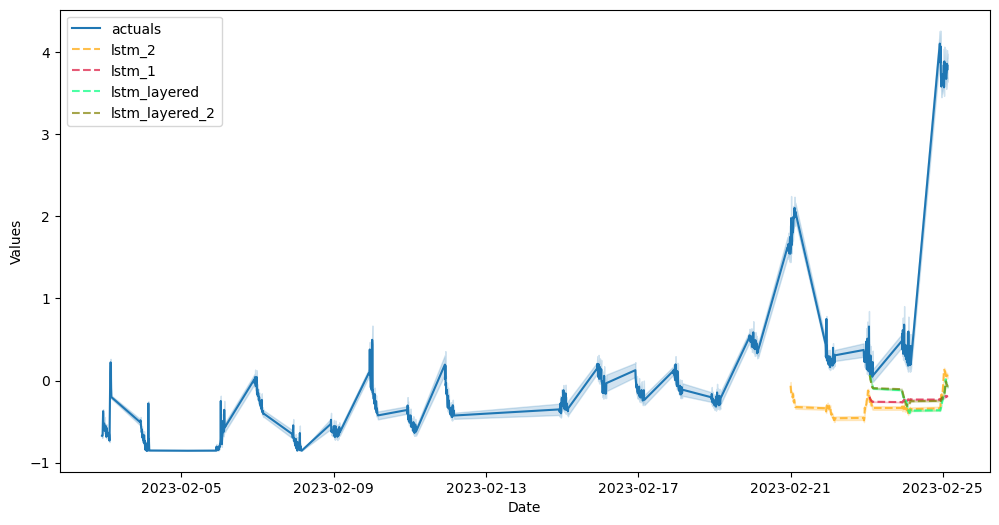

In [68]:
from tensorflow.keras.callbacks import EarlyStopping

f.manual_forecast(call_me = 'lstm_2',
                   lags=40,
                   epochs=25,
                   validation_split=.2,
                   shuffle=True,
                   callbacks=EarlyStopping(
                   monitor='val_loss',
                   patience=5),
                   lstm_layer_sizes=(64,32,32),
                  dropout=(0,0,0)
                  
                   )
f.plot_test_set(ci=True)


1178/1178 [==============================] - 4s 3ms/step


C:\Users\local_admin\anaconda3\lib\site-packages\scalecast\_utils.py:55: Warning: Confidence intervals not found for lstm_2. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
C:\Users\local_admin\anaconda3\lib\site-packages\scalecast\_utils.py:55: Warning: Confidence intervals not found for lstm_1. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
C:\Users\local_admin\anaconda3\lib\site-packages\scalecast\_utils.py:55: Warning: Confidence intervals not found for lstm_layered. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
C:\Users\local_admin\anaconda3\lib\site-packages\scalecast\_utils.py:55: Warning: Confidence intervals not found for lstm_layered_2. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(


<AxesSubplot:xlabel='Date', ylabel='Values'>

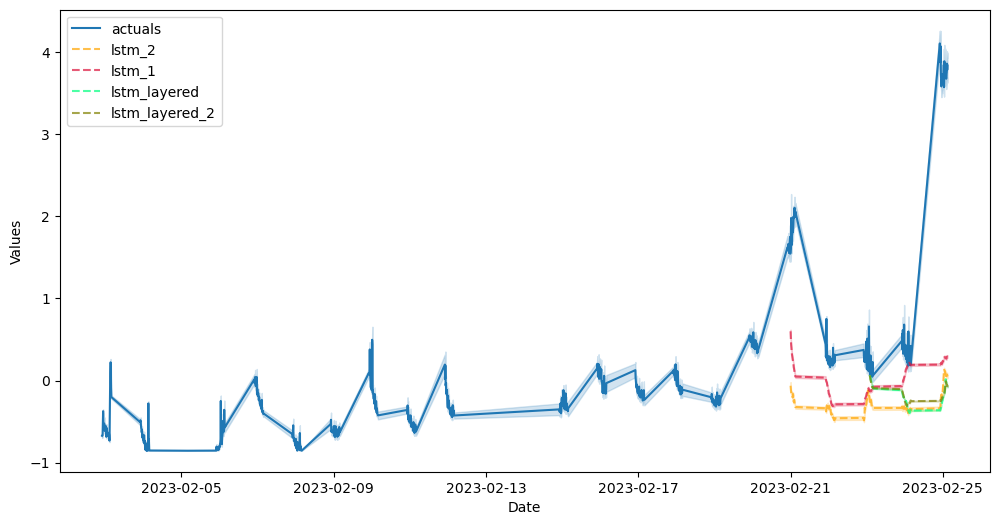

In [69]:
f.manual_forecast(call_me='lstm_1')
f.plot_test_set(ci=True)

1/1 [==============================] - 0s 297ms/step


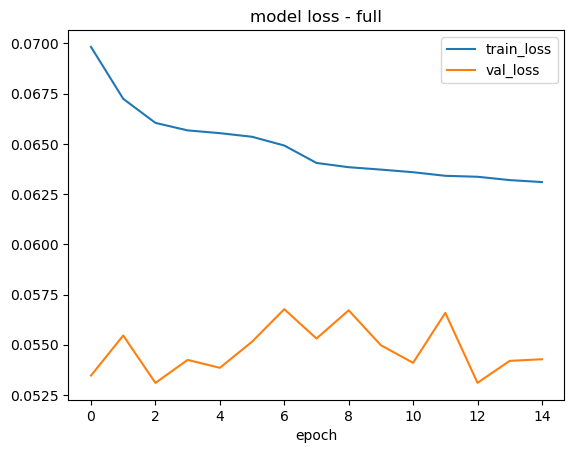

1174/1174 [==============================] - 9s 8ms/step


C:\Users\local_admin\anaconda3\lib\site-packages\scalecast\_utils.py:55: Warning: Confidence intervals not found for lstm_1. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
C:\Users\local_admin\anaconda3\lib\site-packages\scalecast\_utils.py:55: Warning: Confidence intervals not found for lstm_layered. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
C:\Users\local_admin\anaconda3\lib\site-packages\scalecast\_utils.py:55: Warning: Confidence intervals not found for lstm_2. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
C:\Users\local_admin\anaconda3\lib\site-packages\scalecast\_utils.py:55: Warning: Confidence intervals not found for lstm_layered_2. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(


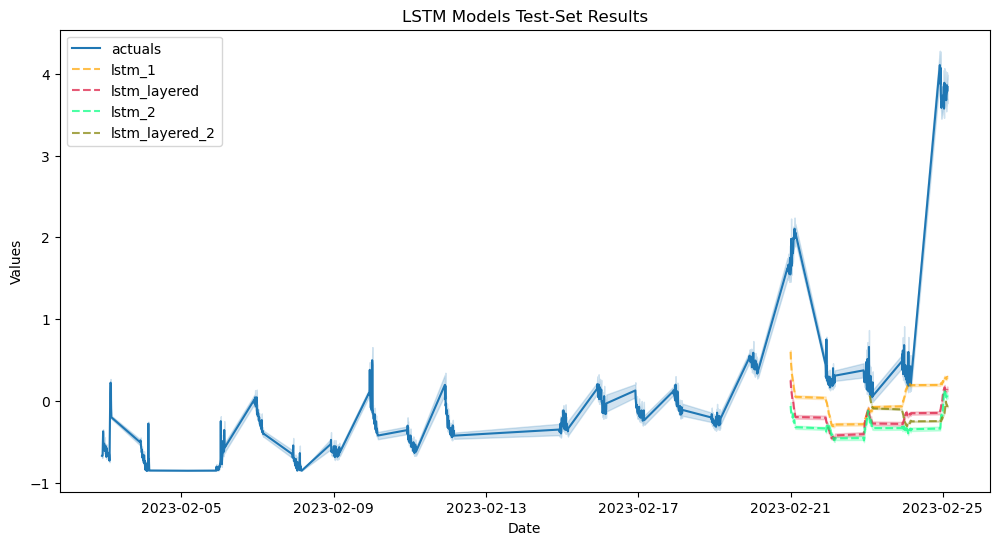

In [70]:
f.manual_forecast(
    lags=120,
    layers_struct=[('LSTM',{'units':100,'dropout':0})]*2 + [('Dense',{'units':10})]*2,
    epochs=15,
    random_seed=42,
    plot_loss=True,
    validation_split=0.2,
    call_me='lstm_layered',
    verbose=0
)
f.plot_test_set(ci=True,order_by='TestSetRMSE')
plt.title('LSTM Models Test-Set Results')
plt.show()

1/1 [==============================] - 0s 312ms/step


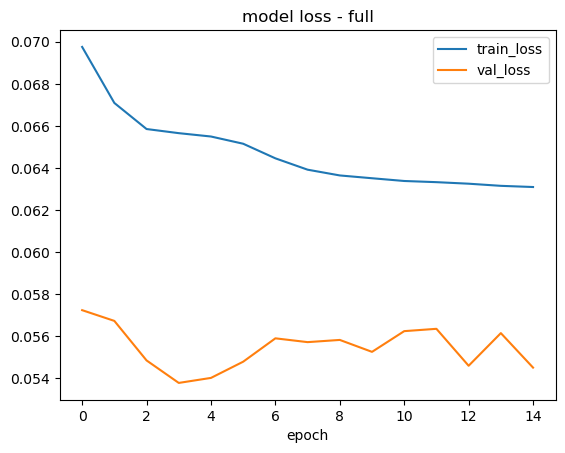

1176/1176 [==============================] - 4s 3ms/step


C:\Users\local_admin\anaconda3\lib\site-packages\scalecast\_utils.py:55: Warning: Confidence intervals not found for lstm_1. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
C:\Users\local_admin\anaconda3\lib\site-packages\scalecast\_utils.py:55: Warning: Confidence intervals not found for lstm_layered_2. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
C:\Users\local_admin\anaconda3\lib\site-packages\scalecast\_utils.py:55: Warning: Confidence intervals not found for lstm_layered. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
C:\Users\local_admin\anaconda3\lib\site-packages\scalecast\_utils.py:55: Warning: Confidence intervals not found for lstm_2. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(


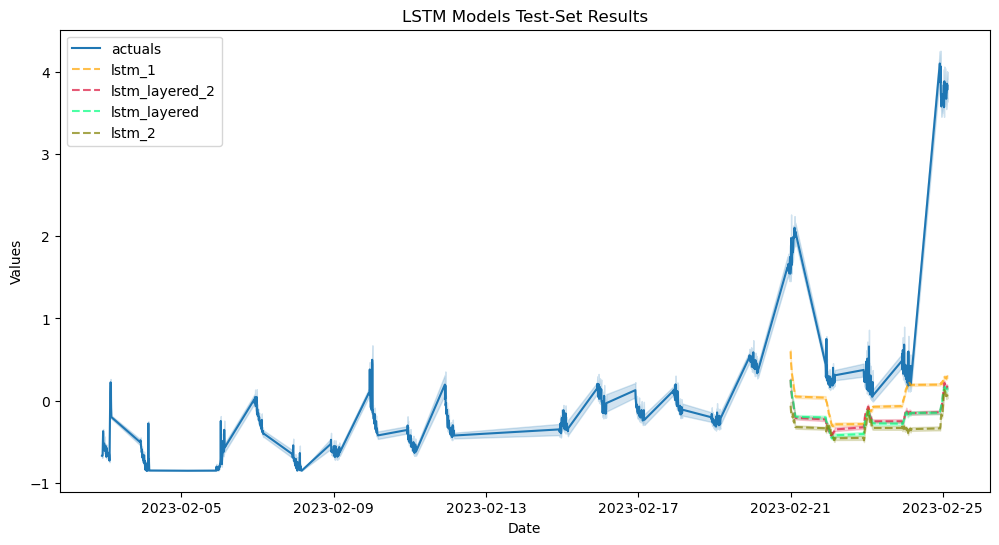

In [71]:
f.manual_forecast(
    lags=50,
    layers_struct=[('LSTM',{'units':64,'dropout':0.1})]*3 + [('Dense',{'units':10})]*2,
    epochs=15,
    random_seed=42,
    plot_loss=True,
    validation_split=0.2,
    call_me='lstm_layered_2',
    verbose=0
)
f.plot_test_set(ci=True,order_by='TestSetRMSE')
plt.title('LSTM Models Test-Set Results')
plt.show()